In [142]:
import sympy
from sympy.tensor.tensor import TensorIndexType, TensorIndex, TensorHead, tensor_indices, TensorSymmetry
from einsteinpy.symbolic import RicciTensor, MetricTensor

sympy.init_printing()

Compute the Einstein tensor.

In [143]:
syms = sympy.symbols("r psi theta phi")
r, psi, theta, phi = syms
f = sympy.Function('f')(r)  # metric ansatz
L = sympy.symbols("L")  # AdS length scale
cap_phi = sympy.Function('Phi')(r)  # defines gauge field

In [144]:
list2d = [[0 for i in range(4)] for i in range(4)]
list2d[0][0] = 1/f
list2d[1][1] = list2d[2][2] = list2d[3][3] = r**2/4
list2d[1][3] = list2d[3][1] = r**2 / 4 * sympy.cos(theta)
sch = MetricTensor(list2d, syms)
sch.tensor()

⎡ 1                            ⎤
⎢────      0      0       0    ⎥
⎢f(r)                          ⎥
⎢                              ⎥
⎢          2           2       ⎥
⎢         r           r ⋅cos(θ)⎥
⎢ 0       ──      0   ─────────⎥
⎢         4               4    ⎥
⎢                              ⎥
⎢                  2           ⎥
⎢                 r            ⎥
⎢ 0        0      ──      0    ⎥
⎢                 4            ⎥
⎢                              ⎥
⎢       2                 2    ⎥
⎢      r ⋅cos(θ)         r     ⎥
⎢ 0    ─────────  0      ──    ⎥
⎣          4             4     ⎦

In [145]:
Ric = RicciTensor.from_metric(sch)
Ric.tensor()

⎡   d                                                                         
⎢-3⋅──(f(r))                                                                  
⎢   dr                                                                        
⎢────────────                  0                              0               
⎢  2⋅r⋅f(r)                                                                   
⎢                                                                             
⎢                       d                                                   ⎛ 
⎢                     r⋅──(f(r))                                            ⎜-
⎢                       dr         f(r)   1                                 ⎝ 
⎢     0             - ────────── - ──── + ─                   0             ──
⎢                         8         2     2                                   
⎢                                                                             
⎢                                                   

In [146]:
metric_array = sympy.MutableDenseNDimArray(list2d)
einstein_tensor = sympy.MutableDenseNDimArray(Ric.tensor()) + 3 / L ** 2 * metric_array

In [147]:
for i in range(4):
    for j in range(4):
        einstein_tensor[i, j] = einstein_tensor[i, j].simplify()
einstein_tensor

⎡    d                                                                        
⎢  3⋅──(f(r))                                                                 
⎢    dr            3                                                          
⎢- ────────── + ───────                        0                              
⎢   2⋅r⋅f(r)     2                                                            
⎢               L ⋅f(r)                                                       
⎢                                                                             
⎢                             2 ⎛    d                    ⎞      2            
⎢                            L ⋅⎜- r⋅──(f(r)) - 4⋅f(r) + 4⎟ + 6⋅r             
⎢                               ⎝    dr                   ⎠                   
⎢          0                 ─────────────────────────────────────            
⎢                                                2                            
⎢                                             8⋅L   

Compute the right-hand side of the Einstein equation.

In [148]:

A_1 = L / 2 * cap_phi * sympy.Array([0, 0, -sympy.sin(psi), sympy.cos(psi) * sympy.sin(theta)])
A_2 = L / 2 * cap_phi * sympy.Array([0, 0, sympy.cos(psi), sympy.sin(psi) * sympy.sin(theta)])
A_3 = L / 2 * cap_phi * sympy.Array([0, 1, 0, sympy.cos(theta)])

In [149]:
A_1, A_2, A_3

⎛⎡      -L⋅Φ(r)⋅sin(ψ)   L⋅Φ(r)⋅sin(θ)⋅cos(ψ)⎤  ⎡      L⋅Φ(r)⋅cos(ψ)  L⋅Φ(r)⋅s
⎜⎢0  0  ───────────────  ────────────────────⎥, ⎢0  0  ─────────────  ────────
⎝⎣             2                  2          ⎦  ⎣            2                

in(ψ)⋅sin(θ)⎤  ⎡   L⋅Φ(r)     L⋅Φ(r)⋅cos(θ)⎤⎞
────────────⎥, ⎢0  ──────  0  ─────────────⎥⎟
 2          ⎦  ⎣     2              2      ⎦⎠

In [150]:
x = [r, psi, theta, phi]
def em_field_strength(A):
    """Compute EM field strength from the vector potential."""    
    F = sympy.MutableDenseNDimArray.zeros(4, 4)
    for i in range(4):
        for j in range(4):
            F[i, j] = sympy.diff(A[j], x[i]) - sympy.diff(A[i], x[j])
    return F

In [151]:
F_1 = em_field_strength(A_1)
F_2 = em_field_strength(A_2)
F_3 = em_field_strength(A_3)

Compute the first term in the energy momentum tensor, involving two field strength tensors with one contraction.

In [152]:
metric_inv = sympy.Matrix(metric_array).inv()
metric_inv

⎡f(r)         0         0          0       ⎤
⎢                                          ⎥
⎢            -4                 4⋅cos(θ)   ⎥
⎢ 0    ───────────────  0   ───────────────⎥
⎢       2    2       2       2    2       2⎥
⎢      r ⋅cos (θ) - r       r ⋅cos (θ) - r ⎥
⎢                                          ⎥
⎢                       4                  ⎥
⎢ 0           0         ──         0       ⎥
⎢                        2                 ⎥
⎢                       r                  ⎥
⎢                                          ⎥
⎢          4⋅cos(θ)               -4       ⎥
⎢ 0    ───────────────  0   ───────────────⎥
⎢       2    2       2       2    2       2⎥
⎣      r ⋅cos (θ) - r       r ⋅cos (θ) - r ⎦

Wrap into a tensor object with appropriate indices.

In [153]:
Euclidean = TensorIndexType('Euclidean', dummy_name='E')
i0, i1, i2, i3, i4, i5, i6, i7 = tensor_indices('i0:8', Euclidean)

In [154]:
FFg_tensor = TensorHead('FFg', [Euclidean] * 6)
FFg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv) +
    sympy.tensorproduct(F_2, F_2, metric_inv) +
    sympy.tensorproduct(F_3, F_3, metric_inv)
)
repl = {FFg_tensor(-i0, -i1, -i2, -i3, i4, i5): FFg_matrix}

Contract indices.

In [155]:
T_contracted_1 = FFg_tensor(-i0, -i1, -i2, -i3, i3, i1).replace_with_arrays(repl)

In [156]:
for i in range(4):
    for j in range(4):
        T_contracted_1[i, j] = T_contracted_1[i, j].simplify()
T_contracted_1

⎡               2                                                             
⎢   2 ⎛d       ⎞                                                              
⎢3⋅L ⋅⎜──(Φ(r))⎟                                                              
⎢     ⎝dr      ⎠                                                              
⎢────────────────                      0                                      
⎢        2                                                                    
⎢       r                                                                     
⎢                                                                             
⎢                        ⎛                  2          ⎞                      
⎢                      2 ⎜ 2      ⎛d       ⎞       2   ⎟                      
⎢                     L ⋅⎜r ⋅f(r)⋅⎜──(Φ(r))⎟  + 8⋅Φ (r)⎟                      
⎢                        ⎝        ⎝dr      ⎠           ⎠                      
⎢       0             ──────────────────────────────

Compute second term of the energy momentum tensor involving two contractions.

In [157]:
FFgg_tensor = TensorHead('FFgg', [Euclidean] * 8)
FFgg_matrix = (
    sympy.tensorproduct(F_1, F_1, metric_inv, metric_inv) +
    sympy.tensorproduct(F_2, F_2, metric_inv, metric_inv) +
    sympy.tensorproduct(F_3, F_3, metric_inv, metric_inv)
)
repl = {FFgg_tensor(-i0, -i1, -i2, -i3, i4, i5, i6, i7): FFgg_matrix}

In [158]:
T_contracted_2 = FFgg_tensor(-i0, -i1, -i2, -i3, i3, i1, i2, i0).replace_with_arrays(repl)

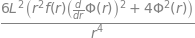

In [159]:
T_contracted_2.simplify()

Compute the energy-momentum tensor.

In [160]:
energy_momentum = 2 * (T_contracted_1 - metric_array / 4 * T_contracted_2)
for i in range(4):
    for j in range(4):
        energy_momentum[i, j] = energy_momentum[i, j].simplify()

In [161]:
energy_momentum

⎡     ⎛                  2          ⎞                                         
⎢   2 ⎜ 2      ⎛d       ⎞       2   ⎟                                         
⎢3⋅L ⋅⎜r ⋅f(r)⋅⎜──(Φ(r))⎟  - 4⋅Φ (r)⎟                                         
⎢     ⎝        ⎝dr      ⎠           ⎠                                         
⎢────────────────────────────────────                       0                 
⎢               4                                                             
⎢              r ⋅f(r)                                                        
⎢                                                                             
⎢                                             ⎛                    2        ⎞ 
⎢                                             ⎜   2      ⎛d       ⎞         ⎟ 
⎢                                             ⎜  r ⋅f(r)⋅⎜──(Φ(r))⎟         ⎟ 
⎢                                           2 ⎜          ⎝dr      ⎠     2   ⎟ 
⎢                                          L ⋅⎜- ───

Evaluate solution.

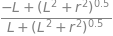

In [162]:
phi_sol = ((L ** 2 + r ** 2) ** (1/2) - L) / ((L ** 2 + r ** 2) ** (1/2) + L) 
phi_sol

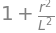

In [163]:
f_sol = 1 + r ** 2 / L ** 2
f_sol

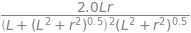

In [164]:
dphidr = sympy.diff(phi_sol, r).simplify()
dphidr

All the components of the Einstein tensor are zero.

In [165]:
for i in range(4):
    for j in range(4):
        print(einstein_tensor[i, j].subs({f: f_sol, cap_phi: phi_sol}).simplify())

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0


All energy momentum components have a similar factor, which goes to zero.

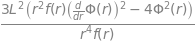

In [166]:
energy_momentum[0, 0]

In [167]:
T_00 = r ** 2 * f_sol * dphidr ** 2 - 4 * phi_sol ** 2

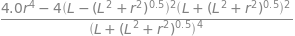

In [168]:
T_00.simplify()

In [169]:
T_00.subs({r: 2, L: 3})